In [1]:
#Importamos las librerias necesarias
import numpy as np
import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
import random

from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/puriarte/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/puriarte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/puriarte/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/puriarte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
bd_tw = pd.read_csv('Data/elonmusk.csv')

### Trabajo Final

#### Understanding Elon Musk Emotions Over Time

#### Working on the database
#Well do some changes to the df so its easier to use

    -Standarize column names so they are easier to use
    -Columns "tweet_id" & "username" not really useful so we can drop them
    -We'll split the "datetime" column so we can be better at splitting periods of time and hours of the day later in the analysis
    
#We'll also play with some new columns doing feature engineering 

    -Creat a new column with the @users tagged in the twits
    -Well use named entity recognition to see what other information we can get



In [3]:
#changing column names to lower case and no spaces
bd_tw.columns = [col.lower().replace(' ', '_') for col in bd_tw.columns]

## Convert the 'datetime' column to datetime format if it's not already
bd_tw['datetime'] = pd.to_datetime(bd_tw['datetime'])

## Create new 'date' column
bd_tw['date'] = bd_tw['datetime'].dt.date

## Create new 'hour' column
bd_tw['hour'] = bd_tw['datetime'].dt.hour

##Drop unuseful columns
bd_tw.drop(columns=['tweet_id', 'username'], inplace=True)
bd_tw.drop(columns=['datetime'], inplace=True)


In [4]:
# Reorder your DataFrame
bd_tw = bd_tw[['date', 'hour', 'text']]

#making every letter to be lower case
bd_tw['text'] = bd_tw['text'].str.lower()

# Add a new column for text length
bd_tw.loc[:, 'text_length'] = bd_tw['text'].str.len()

#Display the modified DF
bd_tw.head(50)

,date,hour,text,text_length
0,2023-05-29,22,@mattyglesias now answer the question,37
1,2023-05-29,22,@mattyglesias insufferable numbskull,36
2,2023-05-29,21,@endwokeness yes,16
3,2023-05-29,20,@sethdillon 🤣,13
4,2023-05-29,19,@teslaownersebay @stevenmarkryan @wholemarsblo...,107
5,2023-05-29,19,"also, you can now change video playback speed",45
6,2023-05-29,19,@krassenstein this is pretty cool,33
7,2023-05-29,19,@stevenmarkryan @wholemarsblog heard diablo iv...,94
8,2023-05-29,18,@joeys_lady @stevenmarkryan @wholemarsblog true,47
9,2023-05-29,18,@drknowitall16 coming soon,26


In [5]:
print(bd_tw)

             date  hour                                               text  \
0      2023-05-29    22              @mattyglesias now answer the question   
1      2023-05-29    22               @mattyglesias insufferable numbskull   
2      2023-05-29    21                                   @endwokeness yes   
3      2023-05-29    20                                      @sethdillon 🤣   
4      2023-05-29    19  @teslaownersebay @stevenmarkryan @wholemarsblo...   
...           ...   ...                                                ...   
23496  2011-12-03     8                  that was a total non sequitur btw   
23497  2011-12-03     8  great voltaire quote, arguably better than twa...   
23498  2011-12-01    10  i made the volume on the model s http://t.co/w...   
23499  2011-12-01     9  went to iceland on sat to ride bumper cars on ...   
23500  2010-06-04    18  please ignore prior tweets, as that was someon...   

       text_length  
0               37  
1               36  


In [6]:
bd_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         23501 non-null  object
 1   hour         23501 non-null  int64 
 2   text         23501 non-null  object
 3   text_length  23501 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 734.5+ KB


In [7]:
#nulls
#assuming df is your DataFrame and 'column_name' is the name of your column
num_nulls = bd_tw['text'].isnull().sum()
print(num_nulls)

print("Shape", bd_tw.shape)

bd_tw.isnull().sum()



0
Shape (23501, 4)


date           0
hour           0
text           0
text_length    0
dtype: int64

#### The data base:
    -Records twits from 2010-06-04 to 2023-05-29
    -Has emojis (which can help the sentiment analysis)
    -"@" refers to people (which we can try to use to valuate sentiments with other people)

#### EDA & GEDA

In [8]:
bd_tw['date'] = pd.to_datetime(bd_tw['date'])

# create a 'year_month' column for grouping
bd_tw['year_month'] = bd_tw['date'].dt.to_period('M')

# group by 'year_month', then aggregate
result = bd_tw.groupby('year_month').agg({'text': ['count'], 'text_length': ['mean']})

In [9]:
result.columns = ['_'.join(col).strip() for col in result.columns.values]


In [10]:
result.head(20)

,text_count,text_length_mean
year_month,,
2010-06,1,92.000000
2011-12,40,111.175000
2012-01,32,106.812500
2012-02,27,102.555556
2012-03,14,99.357143
2012-04,21,106.761905
2012-05,35,106.171429
2012-06,13,94.692308
2012-07,24,113.041667


In [11]:
bd_tw['month'] = bd_tw['date'].dt.month
bd_tw['month'] = bd_tw['date'].dt.month_name()

bd_tw['year'] = bd_tw['date'].dt.year



In [12]:
bd_tw

,date,hour,text,text_length,year_month,month,year
0,2023-05-29,22,@mattyglesias now answer the question,37,2023-05,May,2023
1,2023-05-29,22,@mattyglesias insufferable numbskull,36,2023-05,May,2023
2,2023-05-29,21,@endwokeness yes,16,2023-05,May,2023
3,2023-05-29,20,@sethdillon 🤣,13,2023-05,May,2023
4,2023-05-29,19,@teslaownersebay @stevenmarkryan @wholemarsblo...,107,2023-05,May,2023
...,...,...,...,...,...,...,...
23496,2011-12-03,8,that was a total non sequitur btw,33,2011-12,December,2011
23497,2011-12-03,8,"great voltaire quote, arguably better than twa...",136,2011-12,December,2011
23498,2011-12-01,10,i made the volume on the model s http://t.co/w...,117,2011-12,December,2011
23499,2011-12-01,9,went to iceland on sat to ride bumper cars on ...,140,2011-12,December,2011


In [13]:
tweet_counts_month = bd_tw.groupby('month')['text'].count()

print(tweet_counts_month)


month
April        2766
August       1319
December     2165
February     1870
January      1596
July         1919
June         1669
March        2100
May          3079
November     1997
October      1735
September    1286
Name: text, dtype: int64


In [14]:
tweet_counts = bd_tw.groupby(['year', 'month'])['text'].count().reset_index(name='count')
avg_tweet_counts = tweet_counts.groupby('month')['count'].mean()


In [15]:
tweet_counts = bd_tw.groupby(['year', 'month'])['text'].count().reset_index(name='count')
avg_tweet_counts = tweet_counts.groupby('month')['count'].mean()


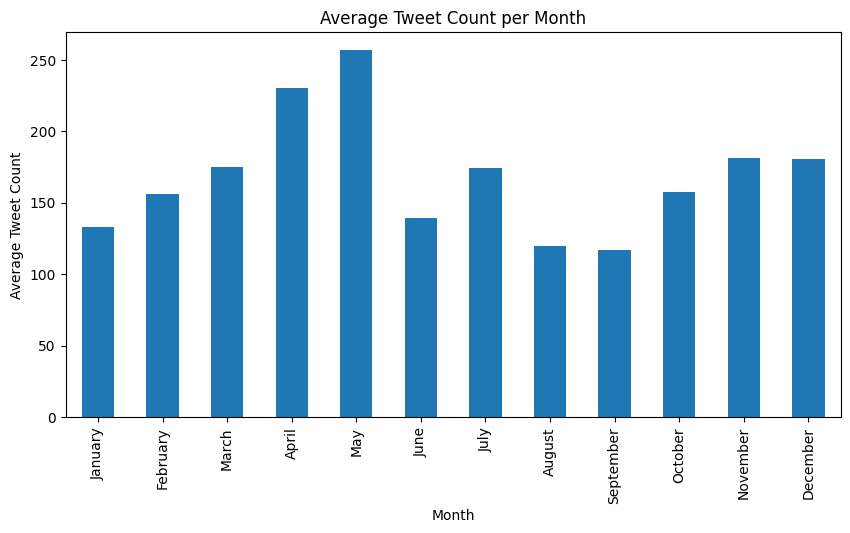

month
January      133.000000
February     155.833333
March        175.000000
April        230.500000
May          256.583333
June         139.083333
July         174.454545
August       119.909091
September    116.909091
October      157.727273
November     181.545455
December     180.416667
Name: count, dtype: float64


In [18]:
##What are the months with more twitts in average

# Ensuring the months are sorted in the right order
months_order = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]
avg_tweet_counts = avg_tweet_counts.reindex(months_order)

# Plotting the data
avg_tweet_counts.plot(kind='bar', figsize=(10, 5))

plt.title('Average Tweet Count per Month')
plt.xlabel('Month')
plt.ylabel('Average Tweet Count')
plt.show()

print(avg_tweet_counts)